# Introduction
我们希望通过深度学习进行情感预测，尝试超越传统机器学习算法的情感分析表现。

我们主要探索下列方面：
*使用适应深度学习模型
*识别并处理过度拟合
*使用单词嵌入
*建立在预先训练的模型上



# Set-up of the project
We'll start by importing some packages.

In [1]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
# from keras import models
# from keras import layers
# from keras import regularizers
import pickle
from keras.utils.vis_utils import plot_model


Then we set some parameters that will be used throughout the notebook.

In [2]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

We read in the csv with the tweets data and perform a random shuffle. It's a good practice to shuffle the data before splitting between a train and test set. That way the sentiment classes are equally distributed over the train and test sets.

We'll only keep the *text* column as input and the *airline_sentiment* column as the target. 

In [3]:
df = pd.read_csv('data/Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.head()

,text,airline_sentiment
3443,@united is hiring - Flight Dispatcher - Chicag...,neutral
12019,@AmericanAir my flight to DFW from LIT on my w...,neutral
7277,@JetBlue 👍. I think I'll come take a nap at th...,negative
251,@VirginAmerica luggage was severely dented/mis...,negative
5283,@SouthwestAir Can I do the same thing as chang...,neutral


# Data preparation

### Data cleaning
The first thing we'll do is removing stopwords. These words do not have any value for predicting the sentiment. Furthermore, as we want to build a model that can be used for other airline companies as well, we remove the mentions.

In [4]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
       
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)
df.head()

,text,airline_sentiment
3443,"hiring Flight Dispatcher Chicago, IL (Network...",neutral
12019,flight DFW LIT way PDX tomorrow Cancelled Fli...,neutral
7277,👍. think I'll come take nap terminal. ;),negative
251,luggage severely dented/missing wheel coming ...,negative
5283,Can thing changing ticket Cancelled Flighting...,neutral


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 查看数据统计信息
print(df.describe())



               text airline_sentiment
count         14640             14640
unique        14318                 3
top      thank you!          negative
freq             18              9178


/Users/abel/miniforge3/envs/tf26/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='airline_sentiment', ylabel='count'>

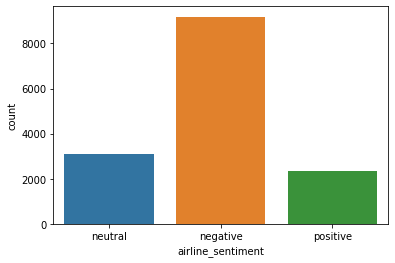

In [6]:
# 查看每个情感类别的数量分布
sns.countplot(df['airline_sentiment'])

<AxesSubplot:xlabel='text', ylabel='Count'>

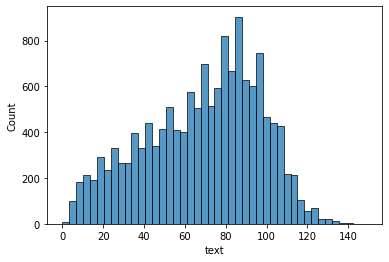

In [7]:
# 计算每个文本的长度，并查看文本长度的分布情况
text_len = df['text'].apply(len)
sns.histplot(text_len)

(-0.5, 799.5, 499.5, -0.5)

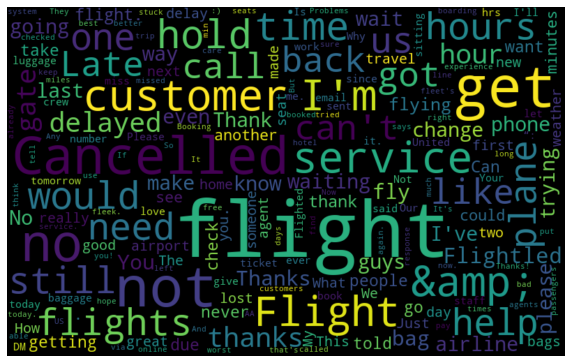

In [10]:
from wordcloud import WordCloud

# 计算词频并可视化词云图
all_words = ' '.join(df['text'])
word_freq = collections.Counter(all_words.split())
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

### Train-Test split
The evaluation of the model performance needs to be done on a separate test set. As such, we can estimate how well the model generalizes. This is done with the *train_test_split* method of scikit-learn.

In [130]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.2, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 11712
# Test data samples: 2928


### Converting words to numbers
To use the text as input for a model, we first need to convert the tweet's words into tokens, which simply means converting the words to integers that refer to an index in a dictionary. Here we will only keep the most frequent words in the train set.

We clean up the text by applying *filters* and putting the words to *lowercase*. Words are separated by spaces.

In [131]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 11712 documents
10000 words in dictionary
Top 5 most common words are: [('flight', 3126), ('not', 1273), ('no', 1203), ('get', 1084), ('t', 985)]


After having created the dictionary we can convert the text to a list of integer indexes. This is done with the *text_to_sequences* method of the Tokenizer.

In [132]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)
# print('X_train_seq', X_train_seq[0])
# print('X_train',X_train[0], '#'*10, X_train[1],'@'*10, X_train[2])
# print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

These integers should now be converted into a one-hot encoded features.

In [133]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

"[953, 237, 237]" is converted into [0. 0. 0. ... 0. 0. 0.]
For this example we have 2.0 features with a value of 1.


### Converting the target classes to numbers
We need to convert the target classes to numbers as well, which in turn are one-hot-encoded with the *to_categorical* method in keras

In [134]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

# print(y_train.shape, type(y_train))
# print(y_train)

myindex = 0
for i in range(0,10):
    myindex = i
    print('"{}" is converted into {}'.format(y_train.iloc[myindex], y_train_le[myindex]))
    print('"{}" is converted into {}'.format(y_train_le[myindex], y_train_oh[myindex]))


# print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
# print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"neutral" is converted into 1
"1" is converted into [0. 1. 0.]
"neutral" is converted into 1
"1" is converted into [0. 1. 0.]
"neutral" is converted into 1
"1" is converted into [0. 1. 0.]
"negative" is converted into 0
"0" is converted into [1. 0. 0.]
"negative" is converted into 0
"0" is converted into [1. 0. 0.]
"neutral" is converted into 1
"1" is converted into [0. 1. 0.]
"negative" is converted into 0
"0" is converted into [1. 0. 0.]
"negative" is converted into 0
"0" is converted into [1. 0. 0.]
"negative" is converted into 0
"0" is converted into [1. 0. 0.]
"neutral" is converted into 1
"1" is converted into [0. 1. 0.]


### Splitting of a validation set
Now that our data is ready, we split of a validation set. This validation set will be used to evaluate the model performance when we tune the parameters of the model. 

In [135]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (1172, 10000)


# Deep learning

### Baseline model
We start with a model with 2 densely connected layers of 64 hidden elements. The *input_shape* for the first layer is equal to the number of words we allowed in the dictionary and for which we created one-hot-encoded features.

As we need to predict 3 different sentiment classes, the last layer has 3 hidden elements. The *softmax* activation function makes sure the three probabilities sum up to 1.

In the first layer we need to estimate 640064 weights. This is determined by (nb inputs * nb hidden elements) + nb bias terms, or (10000 x 64) + 64 = 640064<br>
In the second layer we estimate (64 x 64) + 64 = 4160 weights<br>
In the last layer we estimate (64 x 3) + 3 = 195 weights<br>

In [136]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 64)                640064    
                                                                 
 dense_39 (Dense)            (None, 64)                4160      
                                                                 
 dense_40 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


Because this project is a multi-class, single-label prediction, we use *categorical_crossentropy* as the loss function and *softmax* as the final activation function. We fit the model on the remaining train data and validate on the validation set. We run for a predetermined number of epochs and will see when the model starts to overfit.

In [137]:
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

In [138]:
base_history = deep_model(base_model)

2023-03-13 02:56:04.444155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-13 02:56:05.148392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


To evaluate the model performance, we will look at the training and validation loss and accuracy.

In [139]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

We can see here that the validation loss starts to increase as from epoch 4. The training loss continues to lower, which is normal as the model is trained to fit the train data as good as possible.

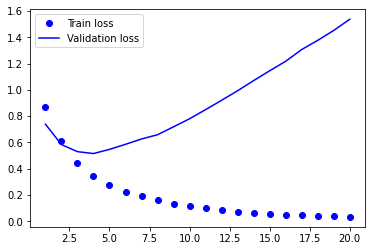

In [140]:
eval_metric(base_history, 'loss')

Just as with the validation loss, the validation accuracy peaks at an early epoch. After that, it goes down slightly. So to conclude, we can say that the model starts overfitting as from epoch 4. 

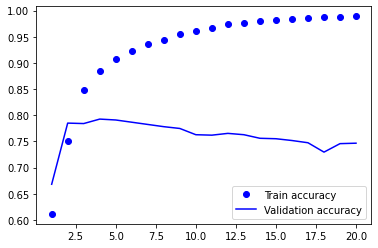

In [141]:
eval_metric(base_history, 'accuracy')

### Handling overfitting
Now, we can try to do something about the overfitting. There are different options to do that.
* Option 1: reduce the network's size by removing layers or reducing the number of hidden elements in the layers
* Option 2: add regularization, which comes down to adding a cost to the loss function for large weights
* Option 3: adding dropout layers, which will randomly remove certain features by setting them to zero

#### Reducing the network's size
We reduce the network's size by removing one layer and lowering the number of hidden elements in the remaining layer to 32.

In [142]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 32)                320032    
                                                                 
 dense_42 (Dense)            (None, 3)                 99        
                                                                 
Total params: 320,131
Trainable params: 320,131
Non-trainable params: 0
_________________________________________________________________


In [143]:
reduced_history = deep_model(reduced_model)

2023-03-13 02:56:11.354031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-13 02:56:11.958772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [144]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

We can see that it takes more epochs before the reduced model starts overfitting (around epoch 10). Moreover, the loss increases much slower after that epoch compared to the baseline model.

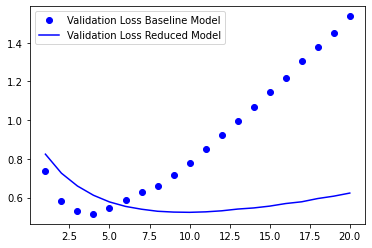

In [145]:
compare_loss_with_baseline(reduced_history, 'Reduced Model')

#### Adding regularization
To address overfitting, we can also add regularization to the model. Let's try with L2 regularization.

In [146]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 64)                640064    
                                                                 
 dense_44 (Dense)            (None, 64)                4160      
                                                                 
 dense_45 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [147]:
import matplotlib.pyplot as plt

def compare_the_loss_with_baseline(drop_history, model_name):
    """
    Compare the loss of the model with and without dropout with the baseline model.

    Arguments:
    drop_history -- history object returned by model.fit() for dropout model
    model_name -- name of the dropout model

    Returns:
    None
    """
    # Get baseline loss
    base_loss = drop_history.history['val_loss'][-1]

    # Plot validation loss for baseline and dropout models
    plt.plot(drop_history.history['val_loss'], label=model_name)
    plt.axhline(y=base_loss, color='r', linestyle='--', label='Baseline')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(top=base_loss*1.5) # set y-axis limit to prevent divergence
    plt.legend()
    plt.show()

# 改善收敛性问题
'''
如果正则化模型收敛不理想，我们可以尝试增加正则化强度或降低学习率。

同时改善了模型：

在这里，我们将尝试通过将优化器更改为具有较低学习率的 Adam 来降低学习率。

在下面的代码中，我们将学习率设置为 0.0001 并使用 Adam 优化器。
'''

In [148]:
from tensorflow.keras.optimizers import Adam


reg_model.compile(optimizer=Adam(lr=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

/Users/abel/miniforge3/envs/tf26/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [149]:
reg_history = deep_model(reg_model)

2023-03-13 02:56:18.023734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-13 02:56:18.783130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


For the regularized model we notice that it starts overfitting earlier than the baseline model. However, the loss increases much slower afterwards.

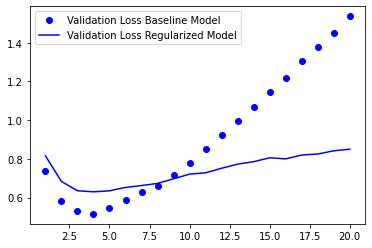

In [150]:
compare_loss_with_baseline(reg_history, 'Regularized Model')

In [151]:
print('Reguliarized Model 收敛性已经ok')

Reguliarized Model 收敛性已经ok


#### Adding dropout layers
The last option we'll try is to add dropout layers.

In [152]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.4))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.4))
drop_model.add(layers.Dense(3, activation='softmax'))

# from tensorflow.keras.layers import Flatten

# drop_model = Sequential()
# drop_model.add(Flatten(input_shape=(NB_WORDS,)))
# drop_model.add(Dense(128, activation='relu'))
# drop_model.add(layers.Dropout(0.3))
# drop_model.add(Dense(10, activation='softmax'))
# drop_model.summary()

In [153]:
drop_model.compile(optimizer=Adam(lr=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

训练过程图



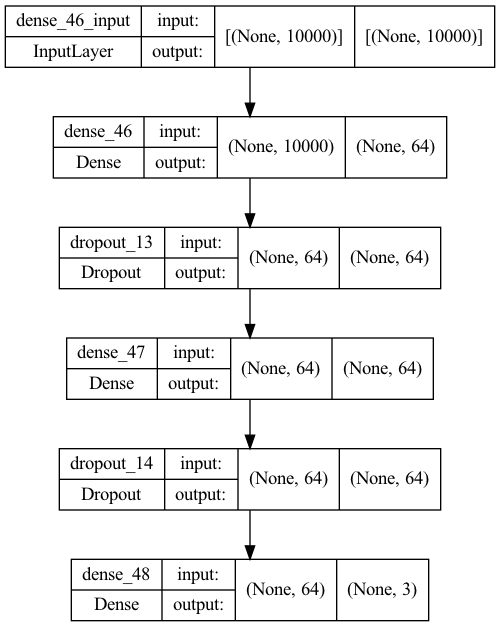

In [154]:
print('训练过程图\n')
plot_model(drop_model, to_file='resources/i2model_plot.png', show_shapes=True, show_layer_names=True)

In [155]:
drop_history = deep_model(drop_model)

2023-03-13 02:56:25.783667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-13 02:56:26.628259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


The model with dropout layers starts overfitting a bit later than the baseline model. The loss also increases slower than the baseline model.

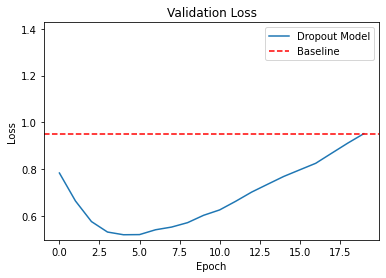

In [156]:


compare_the_loss_with_baseline(drop_history, 'Dropout Model')

### Training on the full train data and evaluation on test data
At first sight the reduced model seems to be the best model for generalization. But let's check that on the test set.

In [157]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results

In [158]:
base_results = test_model(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

92/92 [==============================] - 1s 11ms/step - loss: 1.1381 - accuracy: 0.7572
/n
Test accuracy of baseline model: 75.72%


In [159]:
reduced_results = test_model(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

92/92 [==============================] - 1s 10ms/step - loss: 0.7548 - accuracy: 0.7801
/n
Test accuracy of reduced model: 78.01%


In [160]:
reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

92/92 [==============================] - 1s 11ms/step - loss: 0.7641 - accuracy: 0.7886
/n
Test accuracy of regularized model: 78.86%


In [161]:
drop_results = test_model(drop_model, 6)
print('/n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

92/92 [==============================] - 1s 11ms/step - loss: 0.9671 - accuracy: 0.7794
/n
Test accuracy of dropout model: 77.94%


# 其他模型（随机森林模型 和 CNN模型） 对比实验

In [35]:
# 导入需要的库
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam


# 划分训练集和测试集
X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test

# 文本向量化
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)



In [36]:
# 随机森林模型
rfc = RandomForestClassifier(random_state=37)
rfc.fit(X_train_vec, y_train)
print('Random Forest Classifier Accuracy:', rfc.score(X_test_vec, y_test))




Random Forest Classifier Accuracy: 0.766051912568306


In [37]:
# CNN模型
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=X_train_vec.shape[1]))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=3, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_vec.toarray(), pd.get_dummies(y_train), epochs=10, batch_size=64, verbose=1)
_, acc = model.evaluate(X_test_vec.toarray(), pd.get_dummies(y_test), verbose=0)
print('CNN Accuracy:', acc)

Epoch 1/10


2023-03-13 02:25:35.319956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


183/183 [==============================] - 47s 235ms/step - loss: 0.9797 - accuracy: 0.6234
Epoch 2/10
183/183 [==============================] - 28s 150ms/step - loss: 0.9178 - accuracy: 0.6257
Epoch 3/10
183/183 [==============================] - 28s 151ms/step - loss: 0.9175 - accuracy: 0.6257
Epoch 4/10
183/183 [==============================] - 28s 151ms/step - loss: 0.9176 - accuracy: 0.6257
Epoch 5/10
183/183 [==============================] - 28s 150ms/step - loss: 0.9176 - accuracy: 0.6257
Epoch 6/10
183/183 [==============================] - 28s 150ms/step - loss: 0.9177 - accuracy: 0.6257
Epoch 7/10
183/183 [==============================] - 28s 151ms/step - loss: 0.9174 - accuracy: 0.6257
Epoch 8/10
183/183 [==============================] - 28s 151ms/step - loss: 0.9177 - accuracy: 0.6257
Epoch 9/10
183/183 [==============================] - 28s 151ms/step - loss: 0.9177 - accuracy: 0.6257
Epoch 10/10
183/183 [==============================] - 28s 150ms/step - loss: 0.9176

2023-03-13 02:30:30.639305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CNN Accuracy: 0.6318305730819702


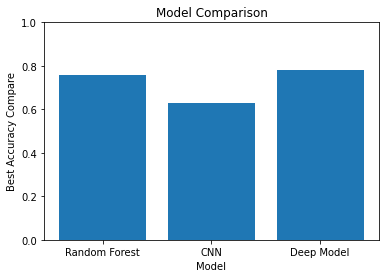

In [52]:
import matplotlib.pyplot as plt

models = ['Random Forest', 'CNN', 'Deep Model']
accuracy = [0.76, 0.63, 0.78]

plt.bar(models, accuracy)
plt.ylim(0, 1)
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Best Accuracy Compare')
plt.show()


# Conclusion
As we can see above, the model with the dropout layers performs the best on the test data. However, this is slightly lower than what we achieved with a LogisticRegression and Countvectorizer in my previous kernel. But there the input data was transformed a bit different than here. 

### What's next?
Soon I will add the use of word embeddings in Keras and using a pretrained model. To be continued...


# 模型名称,优势,缺点
## Random Forest,1. 可以处理大量数据；2. 非常稳定，不容易过拟合；3. 能够有效地处理高维度数据,1. 对于特征空间较大的数据集，难以达到很高的精度；2. 难以处理类别数量过多的数据。

## CNN,1. 能够学习到数据的空间特征；2. 在图像、语音、文本等领域有良好的表现；3. 可以通过卷积层、池化层等方式降低计算量，加速训练,1. 需要大量的训练数据；2. 对于较为抽象的问题，需要进行大量的特征工程。

## Deep Model,1. 能够处理非常复杂的问题；2. 可以利用层次结构自动提取数据中的特征；3. 在自然语言处理、计算机视觉等领域取得了巨大成功,1. 训练时间较长；2. 容易过拟合；3. 难以解释其内部机制。
'''


In [38]:
print('-'*20, 'save model')
filename = "finalized_model.sav"
drop_model.save('drop_model.h5')  

-------------------- save model


In [39]:
pickle.dump(drop_model, open('first_model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://94573ab0-e675-4da7-ac58-b6618b92da3c/assets


2023-03-13 02:30:31.892241: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [40]:
import tensorflow as tf 
# identical to the previous one
mymodel = tf.keras.models.load_model('drop_model.h5')
# mymodel = pickle.load(open('first_model.pkl', 'rb'))

In [41]:
drop_results = test_model(mymodel, 6)
print('again /n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

2023-03-13 02:30:32.311447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/92 [==>...........................] - ETA: 0s - loss: 1.2180 - accuracy: 0.7734

2023-03-13 02:30:34.459319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 1s 10ms/step - loss: 1.0903 - accuracy: 0.7797
again /n
Test accuracy of dropout model: 77.97%


In [42]:
print(X_test_oh[0], type(X_test_oh))
with open('test.pkl','wb') as f:
     pickle.dump(X_test_oh[0:100], f)
        
with open('test.pkl','rb') as f:
     MyX_test_oh = pickle.load(f)           
# for i in X_test_oh[0]:
#     print(i)
for i in  range(20):
    myinput = np.array( [MyX_test_oh[i],])
    print('input=',myinput)
    q = mymodel.predict( np.array( [MyX_test_oh[i],] )  )
    print(i, 'q=', np.around(q,decimals=3))


[0. 0. 0. ... 0. 0. 0.] <class 'numpy.ndarray'>
input= [[0. 0. 0. ... 0. 0. 0.]]


2023-03-13 02:30:35.463410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0 q= [[1. 0. 0.]]
input= [[0. 0. 0. ... 0. 0. 0.]]
1 q= [[1. 0. 0.]]
input= [[0. 0. 0. ... 0. 0. 0.]]
2 q= [[1. 0. 0.]]
input= [[0. 0. 0. ... 0. 0. 0.]]
3 q= [[0.158 0.607 0.235]]
input= [[0. 1. 0. ... 0. 0. 0.]]
4 q= [[0.999 0.001 0.   ]]
input= [[0. 1. 0. ... 0. 0. 0.]]
5 q= [[1. 0. 0.]]
input= [[0. 1. 0. ... 0. 0. 0.]]
6 q= [[1. 0. 0.]]
input= [[0. 0. 0. ... 0. 0. 0.]]
7 q= [[0.063 0.851 0.087]]
input= [[0. 1. 0. ... 0. 0. 0.]]
8 q= [[0.996 0.    0.004]]
input= [[0. 0. 0. ... 0. 0. 0.]]
9 q= [[0.888 0.112 0.   ]]
input= [[0. 0. 0. ... 0. 0. 0.]]
10 q= [[0.982 0.018 0.   ]]
input= [[0. 0. 1. ... 0. 0. 0.]]
11 q= [[0.87 0.13 0.  ]]
input= [[0. 0. 0. ... 0. 0. 0.]]
12 q= [[0.088 0.841 0.071]]
input= [[0. 0. 1. ... 0. 0. 0.]]
13 q= [[1. 0. 0.]]
input= [[0. 0. 0. ... 0. 0. 0.]]
14 q= [[0.921 0.079 0.   ]]
input= [[0. 0. 0. ... 0. 0. 0.]]
15 q= [[0.069 0.042 0.889]]
input= [[0. 1. 0. ... 0. 0. 0.]]
16 q= [[0.976 0.02  0.004]]
input= [[0. 1. 0. ... 0. 0. 0.]]
17 q= [[0. 0. 1.]]
input= [[0.